# LandingAI ADE Intelligent Chunker — Bronze/Silver/Gold Layers + Summaries + Cohere Embeddings + FAISS


This notebook implements a **layout-aware ingestion pipeline** using **LandingAI Agentic Document Extraction (ADE)** parse output.

It maintains the **Bronze / Silver / Gold** layers:

- **Bronze**: raw ADE parse JSON (as-is).
- **Silver**: cleaned + processed chunks, plus **cropped figure/table images** from the PDF using ADE bounding boxes.
- **Gold**: Silver chunks + **summaries** (figures/tables) + **Cohere embeddings** + FAISS indexes for retrieval.

At inference time, it:
1) retrieves relevant text/table chunks → generates an answer with citations  
2) uses cited pages to **narrow the search space** for figures (± window)  
3) retrieves and displays the most relevant images from those pages

<!-- ## Install (run once)

```bash
pip install pymupdf pillow tqdm numpy faiss-cpu cohere openai
# Optional (only if you want to read/write to Google Cloud Storage directly in this notebook)
pip install google-cloud-storage
``` -->


In [2]:
# =========================
# 0) Config
# =========================
import os

# --- Required inputs ---
PDF_LOCAL_PATH = "Internationalisation_of_Higher_Education_in_India_Report_chapter_2.pdf"   # If you already have the PDF locally
PARSE_JSON_PATH = ""                  # Optional fallback: path to an ADE parse JSON file

USER_ID = "user_123"
DOCUMENT_ID = "doc_123"
DOCUMENT_TITLE = "My Document"

# --- Storage mode ---
# If you want to mimic your service's GCS bronze/silver/gold paths, set USE_GCS=True and configure.
USE_GCS = False
GCS_BUCKET = os.environ.get("GCS_BUCKET", "")  # e.g. "my-bucket"
GCS_PREFIX = ""                                # optional prefix within bucket

# --- LandingAI ADE parse options ---
ADE_MODEL = "dpt-2"

# --- OpenAI (for figure/table summaries and final answers) ---
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "")
OPENAI_VISION_MODEL = "gpt-4o-mini"
OPENAI_TEXT_MODEL = "gpt-4o-mini"

# --- Cohere embeddings ---
COHERE_API_KEY = os.environ.get("COHERE_API_KEY", "")
COHERE_EMBED_MODEL = "embed-multilingual-v3.0"

# --- Retrieval params ---
TOP_K_TEXT = 12
TOP_K_IMAGES = 6
CITED_PAGE_WINDOW = 1   # retrieve figures on cited pages ± 1


In [3]:
# =========================
# 1) Storage helpers (Local or GCS)
# =========================
import os, json
from dataclasses import dataclass
from typing import Optional

@dataclass
class StorageRef:
    uri: str          # e.g. "gs://bucket/path" or local path
    local_path: str   # local path (for processing)

class LocalStore:
    def __init__(self, root_dir: str = "artifacts"):
        self.root_dir = root_dir
        os.makedirs(self.root_dir, exist_ok=True)

    def put_bytes(self, rel_path: str, data: bytes, content_type: Optional[str] = None) -> StorageRef:
        path = os.path.join(self.root_dir, rel_path)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "wb") as f:
            f.write(data)
        return StorageRef(uri=path, local_path=path)

    def put_text(self, rel_path: str, text: str, content_type: str = "text/plain") -> StorageRef:
        path = os.path.join(self.root_dir, rel_path)
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w", encoding="utf-8") as f:
            f.write(text)
        return StorageRef(uri=path, local_path=path)

    def put_json(self, rel_path: str, obj) -> StorageRef:
        return self.put_text(rel_path, json.dumps(obj, indent=2, ensure_ascii=False, default=str), content_type="application/json")

class GCSStore(LocalStore):
    """Writes locally (so you can crop/inspect) AND uploads to GCS."""
    def __init__(self, bucket_name: str, prefix: str = "", root_dir: str = "artifacts"):
        super().__init__(root_dir=root_dir)
        from google.cloud import storage  # optional dependency
        self.client = storage.Client()
        self.bucket = self.client.bucket(bucket_name)
        self.prefix = prefix.strip("/")

    def _gcs_path(self, rel_path: str) -> str:
        rel_path = rel_path.lstrip("/")
        if self.prefix:
            return f"{self.prefix}/{rel_path}"
        return rel_path

    def put_bytes(self, rel_path: str, data: bytes, content_type: Optional[str] = None) -> StorageRef:
        ref = super().put_bytes(rel_path, data, content_type=content_type)
        blob_path = self._gcs_path(rel_path)
        blob = self.bucket.blob(blob_path)
        blob.upload_from_string(data, content_type=content_type or "application/octet-stream")
        return StorageRef(uri=f"gs://{self.bucket.name}/{blob_path}", local_path=ref.local_path)

    def put_text(self, rel_path: str, text: str, content_type: str = "text/plain") -> StorageRef:
        ref = super().put_text(rel_path, text, content_type=content_type)
        blob_path = self._gcs_path(rel_path)
        blob = self.bucket.blob(blob_path)
        blob.upload_from_string(text, content_type=content_type)
        return StorageRef(uri=f"gs://{self.bucket.name}/{blob_path}", local_path=ref.local_path)

    def put_json(self, rel_path: str, obj) -> StorageRef:
        return self.put_text(rel_path, json.dumps(obj, indent=2, ensure_ascii=False, default=str), content_type="application/json")

# Choose store
store = GCSStore(GCS_BUCKET, prefix=GCS_PREFIX, root_dir="artifacts") if USE_GCS else LocalStore(root_dir="artifacts")
print("Store:", type(store).__name__)


Store: LocalStore


In [4]:
# =========================
# 2) LandingAI ADE Parse (Bronze)
# =========================
import json
from pathlib import Path
from landingai_ade import LandingAIADE
import os

def ade_parse_pdf(pdf_path: str, model: str = "dpt-2") -> dict:
    """Calls your existing `document_extractor_client.parse` if available.
    Otherwise falls back to reading PARSE_JSON_PATH.
    """
    # Option A: Use your in-repo client (works if you're running this notebook inside your project env)
    try:
        # Use with the SDK
        document_extractor_client = LandingAIADE(
        # Put your API key in the environment variable VISION_AGENT_API_KEY
        apikey=os.environ.get("VISION_AGENT_API_KEY"),
        )
        parse_response = document_extractor_client.parse(document=Path(pdf_path), model=model)
        raw = parse_response.model_dump() if hasattr(parse_response, "model_dump") else parse_response
        if isinstance(raw, str):
            # sometimes SDKs return json string
            raw = json.loads(raw)
        return raw
    except Exception as e:
        if PARSE_JSON_PATH:
            print("Falling back to PARSE_JSON_PATH because ADE client wasn't available:", repr(e))
            return json.load(open(PARSE_JSON_PATH, "r", encoding="utf-8"))
        raise

raw_json_data = ade_parse_pdf(PDF_LOCAL_PATH, model=ADE_MODEL)

# --- Bronze layer write ---
bronze_rel = f"bronze/{USER_ID}/{DOCUMENT_ID}.json"
bronze_ref = store.put_json(bronze_rel, raw_json_data)
print("Bronze saved:", bronze_ref.uri)
print("Top-level keys:", list(raw_json_data.keys())[:10])
print("Chunks count:", len(raw_json_data.get("chunks", [])))


Bronze saved: artifacts\bronze/user_123/doc_123.json
Top-level keys: ['chunks', 'markdown', 'metadata', 'splits', 'grounding']
Chunks count: 135


In [5]:
# =========================
# 3) Silver Layer: clean chunks + crop figures/tables using ADE bounding boxes
# =========================
import os, re, json
import fitz  # PyMuPDF
from typing import List, Dict, Any

ANCHOR_RE = re.compile(r"<a id=['\"][a-f0-9\-]+['\"]></a>\s*", re.IGNORECASE)

def clean_text(s: str) -> str:
    s = s or ""
    return ANCHOR_RE.sub("", s).strip()

def safe_page_index(page_num, doc_len: int) -> int:
    """ADE grounding.page is often 0-based. If you have 1-based, adjust here."""
    if page_num is None:
        return 0
    p = int(page_num)
    # If p is 1..N and doc_len==N, convert to 0-based
    if 1 <= p <= doc_len and (p == doc_len or p == 1):
        # can't be sure; leave as-is unless it would overflow
        pass
    # Prefer treating as 0-based if in range
    if 0 <= p < doc_len:
        return p
    # If 1-based
    if 1 <= p <= doc_len:
        return p - 1
    return 0

chunks = raw_json_data.get("chunks", [])
processed_chunks: List[Dict[str, Any]] = []

doc = fitz.open(PDF_LOCAL_PATH)

for ch in chunks:
    chunk_type = ch.get("type", "text")  # text | figure | table
    chunk_id = str(ch.get("id") or ch.get("chunk_id") or f"chunk_{len(processed_chunks)+1}")

    raw_text = ch.get("markdown") or ch.get("text") or ""
    cleaned_text = clean_text(raw_text)

    page_num = (ch.get("grounding", {}) or {}).get("page")
    page_idx = safe_page_index(page_num, len(doc))
    page_1based = page_idx + 1

    processed = {
        "chunk_id": chunk_id,
        "document_id": DOCUMENT_ID,
        "document_title": DOCUMENT_TITLE,
        "chunk_type": chunk_type,
        "chunk_page_number": page_1based,
        "chunk_processed_content": cleaned_text,  # for text; for figure/table we'll overwrite with summary later
        "chunk_raw_content": cleaned_text,        # overwritten for figure/table with asset ref
        "chunk_bbox": (ch.get("grounding", {}) or {}).get("box", None),
        "chunk_confidence": (ch.get("grounding", {}) or {}).get("confidence", None),
    }

    if chunk_type in ("figure", "table"):
        grounding = ch.get("grounding", {}) or {}
        box = grounding.get("box") or {}
        if box and 0 <= page_idx < len(doc):
            page = doc.load_page(page_idx)
            rect = fitz.Rect(
                box["left"] * page.rect.width,
                box["top"] * page.rect.height,
                box["right"] * page.rect.width,
                box["bottom"] * page.rect.height,
            )
            pix = page.get_pixmap(clip=rect, dpi=200)
            img_bytes = pix.tobytes("png")

            asset_dir = "figures" if chunk_type == "figure" else "tables"
            asset_rel = f"silver/{USER_ID}/{DOCUMENT_ID}/{asset_dir}/{chunk_id}.png"
            asset_ref = store.put_bytes(asset_rel, img_bytes, content_type="image/png")

            # Store where the raw asset lives (GCS or local URI)
            processed["chunk_raw_content"] = asset_ref.uri
            processed["chunk_asset_local_path"] = asset_ref.local_path

    processed_chunks.append(processed)

doc.close()

# Silver layer write
silver_rel = f"silver/{USER_ID}/{DOCUMENT_ID}/chunks.json"
silver_ref = store.put_json(silver_rel, processed_chunks)
print("Silver saved:", silver_ref.uri)
print("Processed chunks:", len(processed_chunks))
print("Example:", processed_chunks[0] if processed_chunks else None)


Silver saved: artifacts\silver/user_123/doc_123/chunks.json
Processed chunks: 135
Example: {'chunk_id': 'c54e6850-013b-42ee-9df3-27cf8e01e2d8', 'document_id': 'doc_123', 'document_title': 'My Document', 'chunk_type': 'figure', 'chunk_page_number': 1, 'chunk_processed_content': 'Chapter\n\n<::transcription of the content\n: figure::>\n\n2', 'chunk_raw_content': 'artifacts\\silver/user_123/doc_123/figures/c54e6850-013b-42ee-9df3-27cf8e01e2d8.png', 'chunk_bbox': {'bottom': 0.601195216178894, 'left': 0.31817862391471863, 'right': 0.6795753240585327, 'top': 0.29403752088546753}, 'chunk_confidence': None, 'chunk_asset_local_path': 'artifacts\\silver/user_123/doc_123/figures/c54e6850-013b-42ee-9df3-27cf8e01e2d8.png'}


In [6]:
# =========================
# 4) Summaries for figures/tables (Silver+)
# =========================
import os, json, base64
from openai import OpenAI

assert OPENAI_API_KEY, "Set OPENAI_API_KEY in env"
client = OpenAI(api_key=OPENAI_API_KEY)

def image_b64(path: str) -> str:
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def summarize_figure(image_path: str) -> str:
    b64 = image_b64(image_path)
    resp = client.responses.create(
        model=OPENAI_VISION_MODEL,
        input=[{
            "role": "user",
            "content": [
                {"type": "input_text", "text": "Write a concise but detailed description of this figure for retrieval. Mention what it shows, labels, entities, and any key takeaways."},
                {"type": "input_image", "image_url": f"data:image/png;base64,{b64}"},
            ],
        }],
    )
    return resp.output_text.strip()

def summarize_table(image_path: str) -> str:
    # If your ADE JSON provides table HTML/markdown, prefer summarizing that instead.
    b64 = image_b64(image_path)
    resp = client.responses.create(
        model=OPENAI_VISION_MODEL,
        input=[{
            "role": "user",
            "content": [
                {"type": "input_text", "text": "This is a table image. Summarize the table for retrieval: what it represents, key columns/rows, and notable values/trends."},
                {"type": "input_image", "image_url": f"data:image/png;base64,{b64}"},
            ],
        }],
    )
    return resp.output_text.strip()

# Cache summaries so re-runs don't re-call the API
cache_rel = f"silver/{USER_ID}/{DOCUMENT_ID}/summaries.json"
cache_local = os.path.join("artifacts", cache_rel)
os.makedirs(os.path.dirname(cache_local), exist_ok=True)
summaries = json.load(open(cache_local, "r", encoding="utf-8")) if os.path.exists(cache_local) else {}

for c in processed_chunks:
    if c["chunk_type"] not in ("figure", "table"):
        continue
    cid = c["chunk_id"]
    if cid in summaries:
        c["chunk_summary"] = summaries[cid]
        c["chunk_processed_content"] = summaries[cid]
        continue

    local_img = c.get("chunk_asset_local_path")
    if not local_img or not os.path.exists(local_img):
        continue

    if c["chunk_type"] == "figure":
        s = summarize_figure(local_img)
    else:
        s = summarize_table(local_img)

    summaries[cid] = s
    c["chunk_summary"] = s
    c["chunk_processed_content"] = s  # IMPORTANT: embedding uses summary for figures/tables

# save cache + re-upload silver chunks (optional)
with open(cache_local, "w", encoding="utf-8") as f:
    json.dump(summaries, f, ensure_ascii=False, indent=2)

store.put_json(cache_rel, summaries)

# update silver chunks to include summaries
store.put_json(f"silver/{USER_ID}/{DOCUMENT_ID}/chunks_with_summaries.json", processed_chunks)

print("Summaries generated:", len(summaries))


Summaries generated: 16


In [7]:
summaries

{'c54e6850-013b-42ee-9df3-27cf8e01e2d8': 'The figure features a bold and simple design highlighting "Chapter 2." It consists of the following elements:\n\n- **Background Color**: A deep maroon surrounding the main content.\n- **Main Element**: A prominent, light orange circle at the center containing the number "2" in a large, white font.\n- **Label**: The word "Chapter" is displayed above the circle in a bold, white font, indicating the section of the text or book.\n\n**Key Takeaways**:\n- The design emphasizes the importance of Chapter 2, suggesting a new section or topic.\n- The color contrast (maroon and orange) is visually striking, enhancing readability and focus on the chapter designation. \n- Overall, the layout indicates a structured approach to navigating the content.',
 '235e8480-1b52-41a5-a9a3-1e9d9151c577': 'The figure presents a framework for "Global Strategies" divided into two primary levels: **Country Level** and **Institutional Level**. \n\n### Key Components:\n\n1. *

In [8]:
# =========================
# 5) Gold Layer: Cohere embeddings + FAISS indexes
# =========================
import os, json
import numpy as np
import faiss
import cohere

assert COHERE_API_KEY, "Set COHERE_API_KEY in env"
co = cohere.ClientV2(api_key=COHERE_API_KEY)

def l2_normalize(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    n = np.linalg.norm(x, axis=1, keepdims=True)
    return x / np.clip(n, eps, None)

def cohere_embed_texts(texts, model: str, input_type: str, batch_size: int = 64) -> np.ndarray:
    vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = [{"content": [{"type": "text", "text": t}]} for t in batch]
        resp = co.embed(model=model, inputs=inputs, input_type=input_type, embedding_types=["float"])
        vecs.append(np.array(resp.embeddings.float_, dtype=np.float32))
    return np.vstack(vecs) if vecs else np.zeros((0, 1), dtype=np.float32)

def build_faiss_ip_index(emb: np.ndarray) -> faiss.Index:
    emb = emb.astype(np.float32)
    idx = faiss.IndexFlatIP(emb.shape[1])
    idx.add(emb)
    return idx

# Embed all chunks (text + summarized figures/tables)
texts = [c["chunk_processed_content"] for c in processed_chunks if c["chunk_processed_content"].strip()]
emb = cohere_embed_texts(texts, model=COHERE_EMBED_MODEL, input_type="search_document")
emb_n = l2_normalize(emb)

# Map embeddings back to chunks (same approach as your service code)
emb_iter = iter(emb_n.tolist())
for c in processed_chunks:
    if c["chunk_processed_content"].strip():
        c["chunk_embedding"] = next(emb_iter)
    else:
        c["chunk_embedding"] = []

# --- Gold layer write ---
gold_rel = f"gold/{USER_ID}/{DOCUMENT_ID}/chunks.json"
gold_ref = store.put_json(gold_rel, processed_chunks)
print("Gold saved:", gold_ref.uri)

# Build FAISS index over all chunk embeddings
vectors = np.array([c["chunk_embedding"] for c in processed_chunks if c.get("chunk_embedding")], dtype=np.float32)
faiss_index = build_faiss_ip_index(vectors)

index_rel = f"gold/{USER_ID}/{DOCUMENT_ID}/faiss.index"
index_local = os.path.join("artifacts", index_rel)
os.makedirs(os.path.dirname(index_local), exist_ok=True)
faiss.write_index(faiss_index, index_local)
store.put_bytes(index_rel, open(index_local, "rb").read(), content_type="application/octet-stream")

# Save metadata mapping from FAISS row -> chunk_id
chunk_ids = [c["chunk_id"] for c in processed_chunks if c.get("chunk_embedding")]
meta_rel = f"gold/{USER_ID}/{DOCUMENT_ID}/faiss_meta.json"
store.put_json(meta_rel, {"chunk_ids": chunk_ids})

print("FAISS index rows:", len(chunk_ids), "dim:", vectors.shape[1])


Gold saved: artifacts\gold/user_123/doc_123/chunks.json
FAISS index rows: 135 dim: 1024


Top retrieved chunks:
- 9a18ed42-03e8-49e7-8633-2dbf6643f899 type=figure p2 score=0.659
- abaf40ea-f76a-47f5-888c-39b24ec12700 type=text p13 score=0.650
- def764a5-0b0e-45e7-a14b-9031fb12f8c0 type=text p18 score=0.626
- 985b78e3-41a0-420e-8b4a-bacbd4a18f13 type=text p16 score=0.581
- e2315132-675f-4e1a-9f69-c56b224933a5 type=text p18 score=0.578
- 34d5b914-2240-4fca-b569-7becd807d51e type=text p15 score=0.575

ANSWER:
 India's strategies in the education system, particularly focused on higher education, include:

1. **Internationalisation**: India aims to develop a comprehensive national strategy for the internationalisation of higher education, leveraging its global diaspora and establishing clear implementation mechanisms [chunk_18].

2. **Context-Specific Approaches**: Tailoring strategies based on unique national needs and priorities, influenced by global best practices [chunk_18].

3. **Integration of Indian Knowledge Systems**: Incorporating traditional Indian disciplines (like A

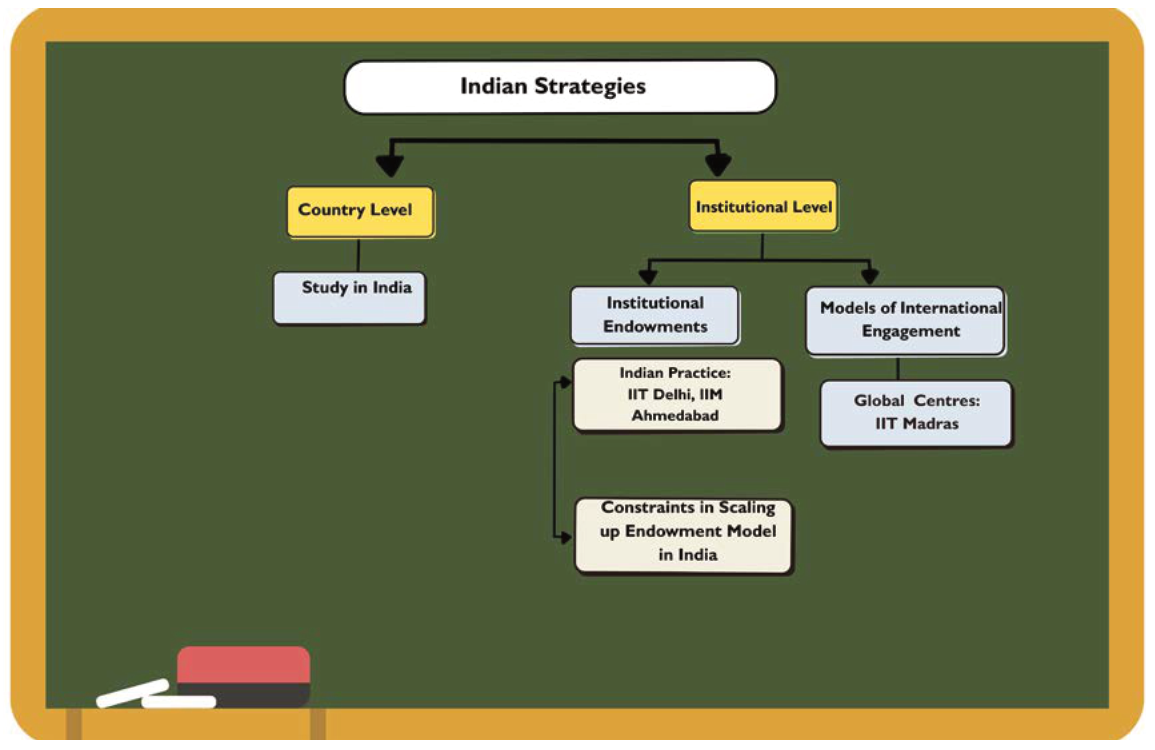

- 235e8480-1b52-41a5-a9a3-1e9d9151c577 p2 score=0.570 asset=artifacts\silver/user_123/doc_123/figures/235e8480-1b52-41a5-a9a3-1e9d9151c577.png


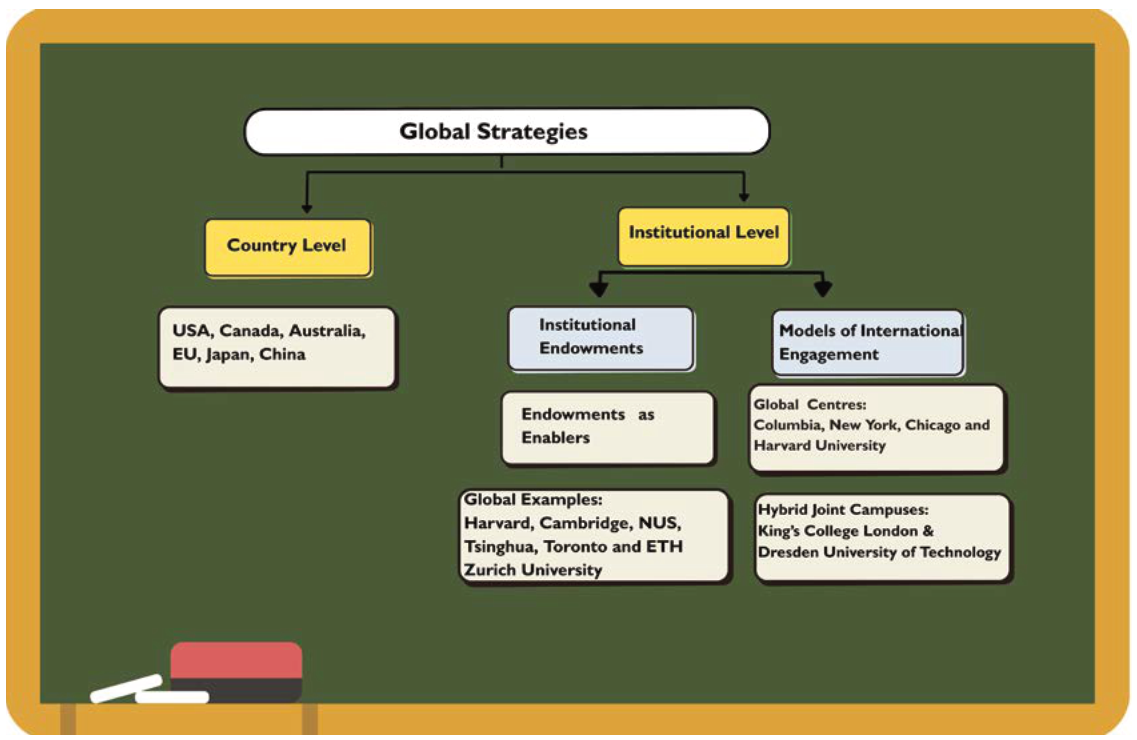

- 8da7df21-00bf-438f-b4a4-1e012f110bd5 p13 score=0.560 asset=artifacts\silver/user_123/doc_123/figures/8da7df21-00bf-438f-b4a4-1e012f110bd5.png


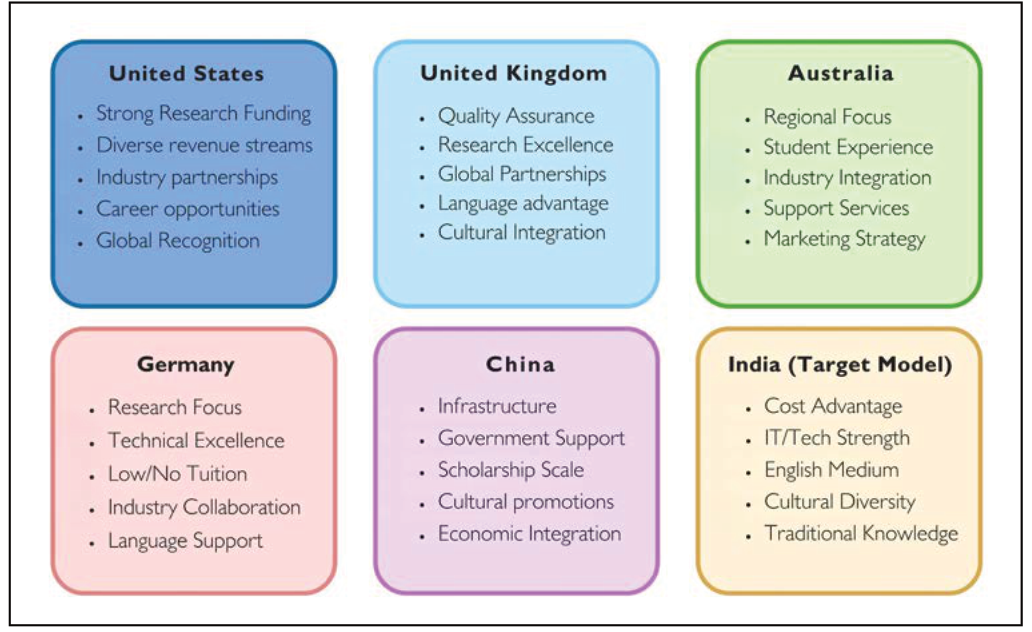

- db068ee0-e1c1-4778-b7df-7c9a0d95ece2 p5 score=0.498 asset=artifacts\silver/user_123/doc_123/figures/db068ee0-e1c1-4778-b7df-7c9a0d95ece2.png


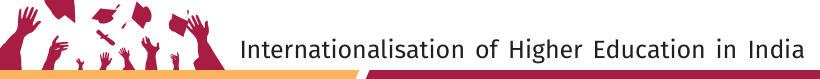

In [9]:
# =========================
# 6) Inference: answer with citations + image retrieval from cited pages (±window)
# =========================
import os, json, re
import numpy as np
import faiss
from openai import OpenAI
from PIL import Image
from IPython.display import display

client = OpenAI(api_key=OPENAI_API_KEY)

# Load index + metadata
index_local = os.path.join("artifacts", f"gold/{USER_ID}/{DOCUMENT_ID}/faiss.index")
faiss_index = faiss.read_index(index_local)
meta = json.load(open(os.path.join("artifacts", f"gold/{USER_ID}/{DOCUMENT_ID}/faiss_meta.json"), "r", encoding="utf-8"))
faiss_chunk_ids = meta["chunk_ids"]

# Build lookup from chunk_id -> chunk dict
chunk_by_id = {c["chunk_id"]: c for c in processed_chunks}

def embed_query(query: str) -> np.ndarray:
    q = cohere_embed_texts([query], model=COHERE_EMBED_MODEL, input_type="search_query")
    return l2_normalize(q)

def search(query: str, top_k: int = 12):
    q = embed_query(query)
    D, I = faiss_index.search(q.astype(np.float32), top_k)
    hits = []
    for score, idx in zip(D[0], I[0]):
        if idx < 0:
            continue
        cid = faiss_chunk_ids[int(idx)]
        hits.append((chunk_by_id[cid], float(score)))
    return hits

def answer_with_citations(query: str, hits):
    # Only feed text/table chunks into the answer context (figures/tables are already summarized, but you can include them too if desired)
    context = []
    for ch, s in hits:
        if ch["chunk_type"] in ("text", "table"):
            context.append(f"[{ch['chunk_id']} | p{ch['chunk_page_number']}] {ch['chunk_processed_content']}")
    ctx = "\n\n".join(context)

    prompt = f"""Answer the question using ONLY the context below.
Cite sources inline using bracketed chunk ids like [chunk_123].
If insufficient information, say so.

Question: {query}

Context:
{ctx}
"""
    resp = client.responses.create(model=OPENAI_TEXT_MODEL, input=prompt)
    return resp.output_text.strip()

def parse_cited_chunk_ids(answer: str):
    # captures [chunk_id] citations
    return re.findall(r"\[([^\]|\n)+\]", answer)

def cited_pages_from_answer(answer: str):
    # Extract chunk_ids inside [ ... ] and map to pages if those chunk_ids exist
    # We accept either [abc] or [abc | p3] patterns; split on whitespace/|.
    cited = re.findall(r"\[([^\]]+)\]", answer)
    pages = set()
    for token in cited:
        cid = token.split("|")[0].strip()
        if cid in chunk_by_id:
            pages.add(int(chunk_by_id[cid]["chunk_page_number"]))
    return pages

def allowed_figures(pages: set, window: int = 1):
    if not pages:
        return [c for c in processed_chunks if c["chunk_type"] == "figure" and c.get("chunk_embedding")]
    allowed = set()
    for p in pages:
        for dp in range(-window, window+1):
            if p + dp >= 1:
                allowed.add(p + dp)
    return [c for c in processed_chunks if c["chunk_type"] == "figure" and int(c["chunk_page_number"]) in allowed and c.get("chunk_embedding")]

def retrieve_figures_filtered(query: str, figs: list, top_k: int = 6):
    if not figs:
        return []
    q = embed_query(query)
    mat = np.array([f["chunk_embedding"] for f in figs], dtype=np.float32)
    sub_index = build_faiss_ip_index(mat)
    D, I = sub_index.search(q.astype(np.float32), min(top_k, len(figs)))
    hits = []
    for score, idx in zip(D[0], I[0]):
        if idx < 0:
            continue
        hits.append((figs[int(idx)], float(score)))
    return hits

QUERY = "What are the indian strategies in education system?"
hits = search(QUERY, top_k=TOP_K_TEXT)

print("Top retrieved chunks:")
for ch, s in hits[:6]:
    print(f"- {ch['chunk_id']} type={ch['chunk_type']} p{ch['chunk_page_number']} score={s:.3f}")

answer = answer_with_citations(QUERY, hits)
print("\nANSWER:\n", answer)

pages = cited_pages_from_answer(answer)
print("\nCited pages:", sorted(pages))

figs = allowed_figures(pages, window=CITED_PAGE_WINDOW)
fig_hits = retrieve_figures_filtered(QUERY, figs, top_k=TOP_K_IMAGES)

print("\nTop figures from cited pages (±window):")
for f, s in fig_hits[:4]:
    print(f"- {f['chunk_id']} p{f['chunk_page_number']} score={s:.3f} asset={f.get('chunk_raw_content')}")
    lp = f.get("chunk_asset_local_path")
    if lp and os.path.exists(lp):
        display(Image.open(lp))



## Where this matches your service code

- **Parse (LandingAI ADE)**: `ade_parse_pdf()` calls `document_extractor_client.parse(document=Path(...), model="dpt-2")` if available.
- **Bronze**: saved to `bronze/{user_id}/{document_id}.json`
- **Silver**:
  - cleans anchor tags
  - crops figures/tables from bounding boxes
  - writes `silver/{user_id}/{document_id}/chunks.json`
  - writes `silver/{user_id}/{document_id}/chunks_with_summaries.json`
- **Gold**:
  - adds `chunk_embedding`
  - writes `gold/{user_id}/{document_id}/chunks.json`
  - writes FAISS + metadata under `gold/{user_id}/{document_id}/`

## Practical adjustments you might want
- If ADE provides **table HTML/markdown**, summarize that instead of summarizing the cropped image.
- If ADE `grounding.page` is definitely **0-based**, simplify `safe_page_index()` accordingly.
- For production, move FAISS + metadata to your vector store / search index (Azure AI Search, Vespa, etc.).
